In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/OIA_ODIR/TrainSet/Train_Images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/OIA_ODIR/TestSet/Test_Images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/OIA_ODIR/ValidSet/val_Images.zip'

Archive:  /content/drive/MyDrive/ResearchWork_2023/OIA_ODIR/TrainSet/Train_Images.zip
replace Images/0_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
Archive:  /content/drive/MyDrive/ResearchWork_2023/OIA_ODIR/TestSet/Test_Images.zip
replace Images/1025_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/ResearchWork_2023/OIA_ODIR/ValidSet/val_Images.zip
replace Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:

# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze the pre-trained weights
base_model.trainable = False

# Pass the input layer through the pre-trained model
features = base_model.output

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dense(units=8, activation='sigmoid')(outputs)

In [ ]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
# f1_score = tfa.metrics.F1Score(num_classes=8)
# categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:

# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', precision , recall])

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:

# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023/OIA_ODIR'
train_df = pd.read_excel(f'{base_path}/TrainSet/Annotation/train_labels.xlsx')
test_df = pd.read_excel(f'{base_path}/TestSet/Annotation/test_labels.xlsx')
val_df = pd.read_excel(f'{base_path}/ValidSet/Annotation/val_labels.xlsx')


In [ ]:
train_df

,Unnamed: 0.1,Unnamed: 0,Fundus,Diagnostic_Keywords,N,D,G,C,A,H,M,O
0,0,0,0_left.jpg,cataract,0,0,0,1,0,0,0,0
1,1,1,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0
2,2,2,2_left.jpg,laser spot，moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,3,3_left.jpg,normal fundus,1,0,0,0,0,0,0,0
4,4,4,4_left.jpg,macular epiretinal membrane,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6954,3478,3495,4686_right.jpg,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
6955,3479,3496,4688_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
6956,3480,3497,4689_right.jpg,normal fundus,1,0,0,0,0,0,0,0
6957,3481,3498,4690_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


# Train

In [ ]:
labels = val_df.iloc[:, 4:].values

In [ ]:
labels

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
# Split the data into two arrays, one for the image paths and one for the labels
train_images_base_path = '/content/Images/'
image_paths = train_images_base_path + train_df["Fundus"].values
labels = train_df.iloc[:, 4:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Test

In [ ]:

# Split the data into two arrays, one for the image paths and one for the labels
test_images_base_path = '/content/Images/'
image_paths = test_images_base_path + test_df["Fundus"].values
labels = test_df.iloc[:, 4:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Validation

In [ ]:
# Split the data into two arrays, one for the image paths and one for the labels
val_images_base_path = '/content/Images/'
image_paths = val_images_base_path + val_df["Fundus"].values
labels = val_df.iloc[:, 4:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
val_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [ ]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
train_dataset = train_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
# Train the model
history=model.fit(train_dataset, epochs=20, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/20
218/218 [==============================] - 179s 683ms/step - loss: 0.3167 - accuracy: 0.5087 - precision: 0.5475 - recall: 0.4120 - val_loss: 0.3744 - val_accuracy: 0.3715 - val_precision: 0.4163 - val_recall: 0.2413
Epoch 2/20
218/218 [==============================] - 123s 512ms/step - loss: 0.2360 - accuracy: 0.6001 - precision: 0.6621 - recall: 0.5115 - val_loss: 0.3631 - val_accuracy: 0.5010 - val_precision: 0.5067 - val_recall: 0.4337
Epoch 3/20
218/218 [==============================] - 125s 521ms/step - loss: 0.2040 - accuracy: 0.6597 - precision: 0.7174 - recall: 0.5631 - val_loss: 0.3507 - val_accuracy: 0.4548 - val_precision: 0.4980 - val_recall: 0.3538
Epoch 4/20
218/218 [==============================] - 143s 608ms/step - loss: 0.1881 - accuracy: 0.6804 - precision: 0.7430 - recall: 0.6088 - val_loss: 0.3766 - val_accuracy: 0.4659 - val_precision: 0.4647 - val_recall: 0.4240
Epoch 5/20
218/218 [==============================] - 124s 512ms/step - loss: 0.1706 - a

In [ ]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_vgg19_m.h5')

In [ ]:
import matplotlib.pyplot as plt

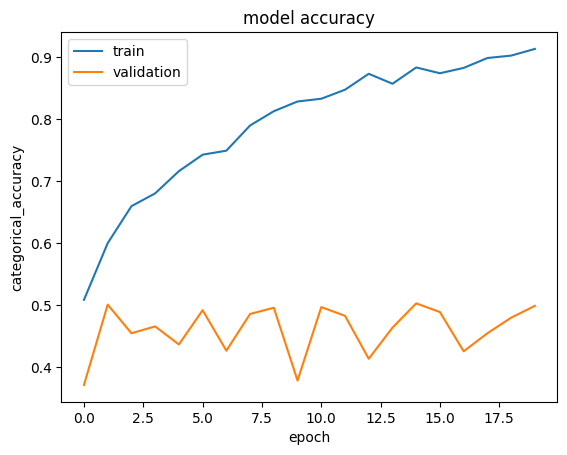

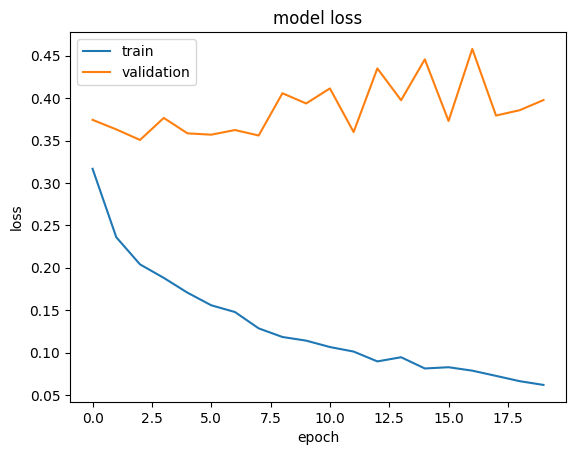

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
result = model.evaluate(test_dataset)
result

63/63 [==============================] - 41s 427ms/step - loss: 0.4350 - accuracy: 0.4597 - precision: 0.4714 - recall: 0.3972


[0.43497350811958313,
 0.45968952775001526,
 0.47137072682380676,
 0.3971734941005707]

In [ ]:
# load_model = tf.keras.saving.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_4.h5',compile=False)

In [ ]:
import numpy as np

# Assuming you have a test dataset 'test_data' with image tensors and corresponding labels
predictions = []
true_labels = []

# Iterate over the test dataset and make predictions
for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

# Compute the confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)

# Convert the confusion matrix to a NumPy array and print it
print("Confusion Matrix:")
print(cm.numpy())


1/1 [==============================] - 3s 3s/step
Confusion Matrix:
[[669 139  13   4   0   2   3  14]
 [131  76   1   1   0   0   2   2]
 [ 57   7   9   1   0   0   0   5]
 [ 17   6   1  68   0   0   0   2]
 [ 48  15   1   0   3   0   0   6]
 [ 20  11   0   0   0   1   0   3]
 [  9   0   2   2   0   0  47   3]
 [326 138  15  10  12   3  47  45]]
